# Exploring correlation

**What**: calculate the correlation between different market indexes.

**Reference**:
- https://aroussi.com/post/python-yahoo-finance
- https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

In [180]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import yfinance as yf
from yellowbrick.features import joint_plot

Example `yfinance`

In [2]:
date = '2015-01-01'

In [3]:
test = yf.Ticker('^BVSP')
test.info

{'exchange': 'SAO',
 'shortName': 'IBOVESPA',
 'exchangeTimezoneName': 'America/Sao_Paulo',
 'exchangeTimezoneShortName': 'BRT',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '-10800000',
 'quoteType': 'INDEX',
 'symbol': '^BVSP',
 'messageBoardId': 'finmb_INDEXBVSP',
 'market': 'br_market',
 'previousClose': 109349.37,
 'regularMarketOpen': 109349,
 'twoHundredDayAverage': 112886.33,
 'trailingAnnualDividendYield': None,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 110701.66,
 'navPrice': None,
 'averageDailyVolume10Day': 9823410,
 'totalAssets': None,
 'regularMarketPreviousClose': 109349.37,
 'fiftyDayAverage': 114916,
 'trailingAnnualDividendRate': None,
 'open': 109349,
 'toCurrency': None,
 'averageVolume10days': 9823410,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 108905.49,
 'priceHint': 2,
 'currency': 

In [4]:
ibov = yf.download(tickers='^BVSP')[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [5]:
ibov = ibov[ibov.index >= date] 
ibov_acum = (ibov.pct_change() + 1).cumprod()
ibov_acum.iloc[0] = 1

ibov_acum

,Adj Close
Date,
2015-01-02,1.000000
2015-01-05,0.979490
2015-01-06,0.989467
2015-01-07,1.019603
2015-01-08,1.029498
...,...
2022-04-22,2.289702
2022-04-25,2.281600
2022-04-26,2.230644


Example BCB SGS

In [140]:
dict_bcb = {
    'CDI': 12,
    'SELIC': 432,
    'IPCA': 433,
    'IGPM': 189,
}

In [141]:
def api_bcb(key, date):
    '''Objetive: return a dataframe of code's index'''

    url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{dict_bcb[key]}/dados?formato=json'
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    #api finished

    df = df[df.index >= date]
    df.set_axis([key], axis=1, inplace=True)
    #data ready
    
    return df

In [142]:
cdi = api_bcb('CDI', date)
cdi_acum = (1 + cdi/100).cumprod()
cdi_acum.iloc[0] = 1
cdi_acum

,CDI
data,
2015-01-02,1.000000
2015-01-05,1.000869
2015-01-06,1.001304
2015-01-07,1.001739
2015-01-08,1.002175
...,...
2022-04-20,1.768854
2022-04-22,1.769628
2022-04-25,1.770402


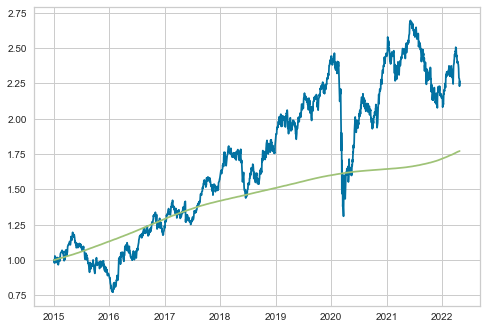

In [143]:
fig, ax = plt.subplots()
ax.plot(ibov_acum)
ax.plot(cdi_acum)

Consolidating indexes in a single dataframe

In [172]:
cdi = api_bcb('CDI', date)
selic = api_bcb('SELIC', date)
ipca = api_bcb('IPCA', date)
igpm = api_bcb('IGPM', date)

#dataframe 1
#consolidation indexes into dataframe
df_index = pd.concat([ibov, cdi, selic, ipca, igpm], axis=1)
df_index.dropna(inplace=True)
df_index.head()

,ibov,CDI,SELIC,IPCA,IGPM
2015-04-01,52322.0,0.047103,12.75,0.71,1.17
2015-06-01,53031.0,0.048967,13.25,0.79,0.67
2015-07-01,52758.0,0.050753,13.75,0.62,0.69
2015-09-01,45477.0,0.052461,14.25,0.54,0.95
2015-10-01,45313.0,0.052461,14.25,0.82,1.89


In [200]:
def calculate_variation(df_input, column_name):
    '''Objective: return the variation of time series'''
    df = df_input[[column_name]].copy(deep=True)
    #df.set_axis(['index'], axis=1, inplace=True)
    #dataframe ready

    df['shift'] = df.shift(1)
    df[column_name] = round((df[column_name] - df['shift'])/df['shift'], 2)
    #variation ready

    #df.rename(columns={'var':column_name}, inplace=True)

    return df[column_name]


#dataframe 2
#consolidation indexes variation into dataframe
a = calculate_variation(df_index, 'ibov')
b = calculate_variation(df_index, 'CDI')
c = calculate_variation(df_index, 'SELIC')
d = calculate_variation(df_index, 'IPCA')
e = calculate_variation(df_index, 'IGPM')

df = pd.concat([a, b, c, d, e], axis=1)
df.dropna(inplace=True)
df

,ibov,CDI,SELIC,IPCA,IGPM
2015-06-01,0.01,0.04,0.04,0.11,-0.43
2015-07-01,-0.01,0.04,0.04,-0.22,0.03
2015-09-01,-0.14,0.03,0.04,-0.13,0.38
2015-10-01,-0.00,0.00,0.00,0.52,0.99
2015-12-01,-0.01,0.00,0.00,0.17,-0.74
2016-02-01,-0.10,-0.00,0.00,-0.06,1.63
2016-03-01,0.09,0.00,0.00,-0.52,-0.60
2016-04-01,0.15,0.00,0.00,0.42,-0.35
2016-06-01,-0.03,0.00,0.00,-0.43,4.12
2016-07-01,0.07,0.00,0.00,0.49,-0.89


## Correlation

In [175]:
pg.corr(df['ibov'], df['CDI'], method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,50,0.006376,"[-0.27, 0.28]",0.96495,0.177,0.049908


In [176]:
pg.corr(df['ibov'], df['CDI'], method='spearman')

,n,r,CI95%,p-val,power
spearman,50,-0.134706,"[-0.4, 0.15]",0.350982,0.154755


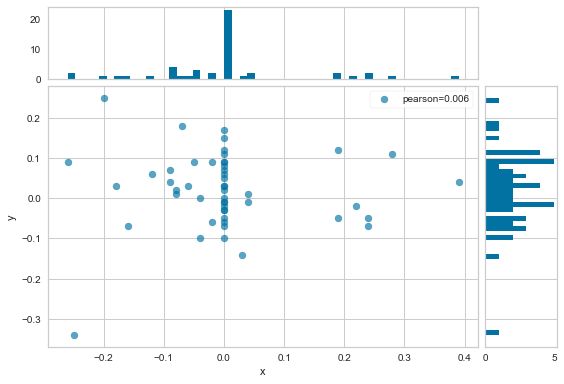

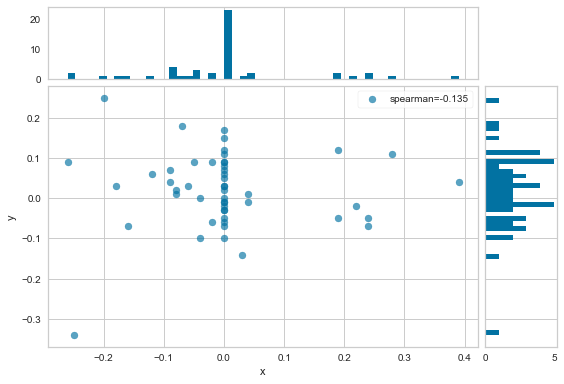

JointPlot(ax=<AxesSubplot:xlabel='x', ylabel='y'>, correlation='spearman')

In [187]:
joint_plot(df['CDI'], df['ibov'], correlation='pearson')
joint_plot(df['CDI'], df['ibov'], correlation='spearman')

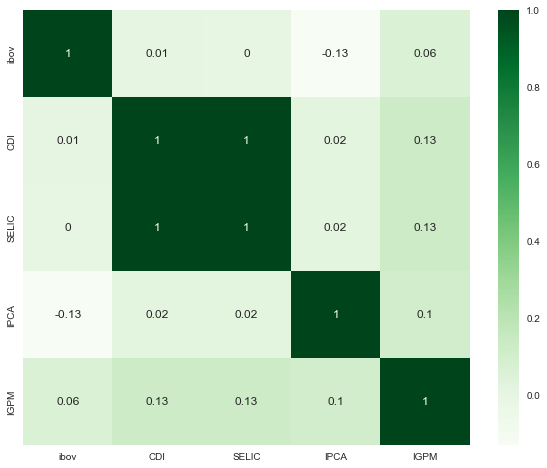

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.subplots(figsize=(10, 8))
corr = df.corr().round(2)
sns.heatmap(corr, cmap='Greens', annot=True)
plt.show()